# Dose map from neutrons

This task simulates dose from a pulse of neutrons on a regular mesh.

The regular mesh values are then used to create a dose map showing dose limits

In [392]:
# import plotly.graph_objects as go
import openmc
from pathlib import Path
# Setting the cross section path to the correct location in the docker image.
# If you are running this outside the docker image you will have to change this path to your local cross section path.
openmc.config['cross_sections'] = Path.home() / 'nuclear_data' / 'cross_sections.xml'

We define the materials used in the simulation, we are using air and concrete.

In [393]:
mat_air = openmc.Material(name="air")
mat_air.add_element("N", 0.784431)
mat_air.add_element("O", 0.210748)
mat_air.add_element("Ar", 0.0046)
mat_air.set_density("g/cc", 0.001205)

mat_concrete = openmc.Material(name='concrete')
mat_concrete.add_element("H",0.168759)
mat_concrete.add_element("C",0.001416)
mat_concrete.add_element("O",0.562524)
mat_concrete.add_element("Na",0.011838)
mat_concrete.add_element("Mg",0.0014)
mat_concrete.add_element("Al",0.021354)
mat_concrete.add_element("Si",0.204115)
mat_concrete.add_element("K",0.005656)
mat_concrete.add_element("Ca",0.018674)
mat_concrete.add_element("Fe",0.00426)
mat_concrete.set_density("g/cm3", 0.023)  # todo corecct to 2.3

materials = openmc.Materials([mat_air, mat_concrete])

Next we define some parameters that will be used for the bio shield construction

In [394]:
floor_thickness = 200
wall_thickness = 200
ceiling_thickness = 150
inner_cell_y_width = 1000
inner_cell_x_width = 1000
inner_cell_height = 1000
door_to_wall_gap = 50
door_thickness = 200
door_way_left_offset = 100
door_way_length = 400
door_overlap = 50
door_left_offset = door_way_left_offset - door_overlap
door_length = door_way_length + door_overlap * 2
padding = 100
# , boundary_type='vacuum'

Then we define the geometry, which is just a shielded room

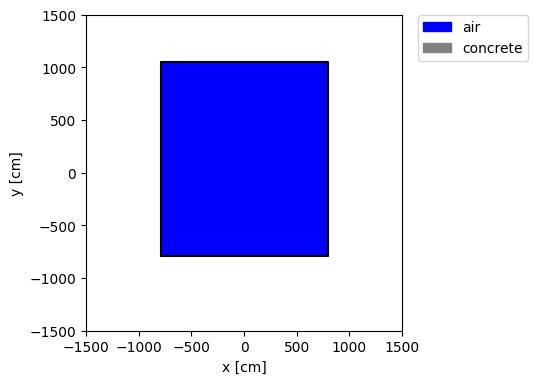

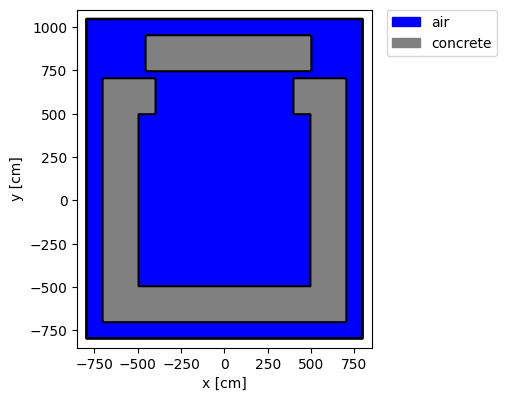

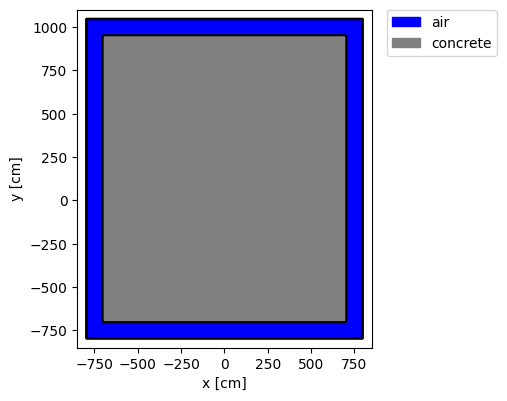

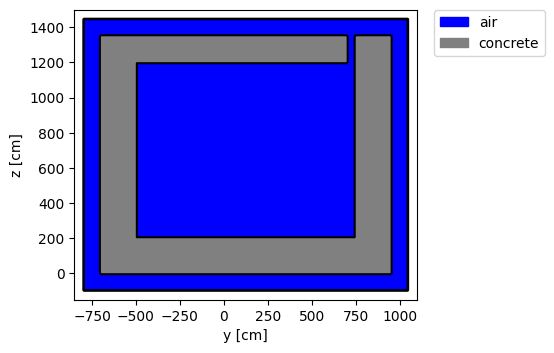

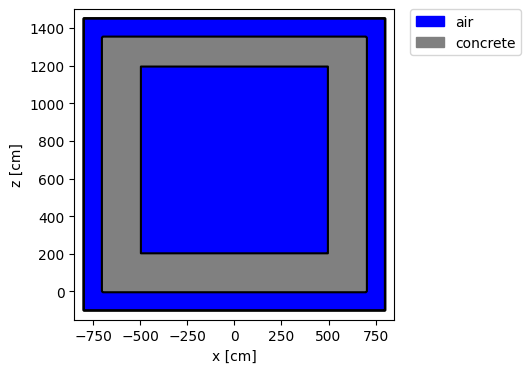

In [395]:

lower_floor = openmc.ZPlane(z0=0)
upper_floor = openmc.ZPlane(z0=floor_thickness)
lower_ceiling = openmc.ZPlane(z0=upper_floor.z0+inner_cell_height)
upper_ceiling = openmc.ZPlane(z0=lower_ceiling.z0+ceiling_thickness)

left_wall_inner_wall = openmc.XPlane(x0=-(inner_cell_x_width/2))
right_wall_inner_wall = openmc.XPlane(x0=inner_cell_x_width/2)
left_wall_outer_wall = openmc.XPlane(x0=left_wall_inner_wall.x0-wall_thickness)
right_wall_outer_wall = openmc.XPlane(x0=right_wall_inner_wall.x0+wall_thickness)

lower_wall_inner_wall = openmc.YPlane(y0=-(inner_cell_y_width/2))
lower_wall_outer_wall = openmc.YPlane(y0=lower_wall_inner_wall.y0 - wall_thickness)
top_wall_inner_wall = openmc.YPlane(y0=inner_cell_y_width/2)
top_wall_outer_wall = openmc.YPlane(y0=top_wall_inner_wall.y0+wall_thickness)

door_inner_wall = openmc.YPlane(y0=top_wall_outer_wall.y0+door_to_wall_gap)
door_outer_wall = openmc.YPlane(y0=door_inner_wall.y0+door_thickness)

door_left = openmc.XPlane(x0=left_wall_inner_wall.x0+door_left_offset)
door_right = openmc.XPlane(x0=door_length)
doorway_left = openmc.XPlane(x0=left_wall_inner_wall.x0+door_way_left_offset)
doorway_right = openmc.XPlane(x0=door_way_length)

door_region = -door_outer_wall & +door_inner_wall & +door_left &-door_right & +upper_floor &-upper_ceiling
left_of_door_region = +left_wall_outer_wall & -door_outer_wall & +door_inner_wall & -door_left & +upper_floor &-upper_ceiling
right_of_door_region = -right_wall_outer_wall & -door_outer_wall & +door_inner_wall & +door_right & +upper_floor &-upper_ceiling

left_wall_region = +left_wall_outer_wall & -left_wall_inner_wall & -top_wall_inner_wall & +lower_wall_inner_wall & -lower_ceiling & +upper_floor
right_wall_region = -right_wall_outer_wall & +right_wall_inner_wall & -top_wall_inner_wall & +lower_wall_inner_wall & -lower_ceiling & +upper_floor

top_left_wall_region = -top_wall_outer_wall & +top_wall_inner_wall & +left_wall_outer_wall & -doorway_left & -lower_ceiling & +upper_floor
top_right_wall_region = -top_wall_outer_wall & +top_wall_inner_wall & +doorway_right & -right_wall_outer_wall & -lower_ceiling & +upper_floor

door_way_region = -top_wall_outer_wall & +top_wall_inner_wall & -doorway_right  & +doorway_left & -lower_ceiling & +upper_floor
lower_wall_region = +lower_wall_outer_wall & -lower_wall_inner_wall & +left_wall_outer_wall & -right_wall_outer_wall & -lower_ceiling & +upper_floor

inner_region = +left_wall_inner_wall & -right_wall_inner_wall & -top_wall_inner_wall & +lower_wall_inner_wall & -lower_ceiling & +upper_floor

floor_region = -upper_floor & +lower_floor & +left_wall_outer_wall & -right_wall_outer_wall & -top_wall_outer_wall & +lower_wall_outer_wall
floor_region_below_door_gap = -upper_floor & +lower_floor & -door_outer_wall & +top_wall_outer_wall & +left_wall_outer_wall & -right_wall_outer_wall

air_region_in_door_gap = -upper_ceiling & +upper_floor & -door_inner_wall & +top_wall_outer_wall & +left_wall_outer_wall & -right_wall_outer_wall
ceiling_region = -upper_ceiling & +lower_ceiling & +left_wall_outer_wall & -right_wall_outer_wall & -top_wall_outer_wall & +lower_wall_outer_wall

# outer_box_bottom = openmc.ZPlane(z0=lower_floor.z0-padding)
# outer_box_top = openmc.ZPlane(z0=upper_ceiling.z0+padding)
# outer_box_left = openmc.XPlane(x0=left_wall_outer_wall.x0-padding)
# outer_box_right = openmc.XPlane(x0=right_wall_outer_wall.x0+padding)
# outer_box_front = openmc.YPlane(y0=door_outer_wall.y0+padding)
# outer_box_back = openmc.YPlane(y0=lower_wall_outer_wall.y0-padding)

outer_box = openmc.model.RectangularParallelepiped(
    xmin=left_wall_outer_wall.x0-padding,
    xmax=right_wall_outer_wall.x0+padding,
    ymin=lower_wall_outer_wall.y0-padding,
    ymax=door_outer_wall.y0+padding,
    zmin=lower_floor.z0-padding,
    zmax=upper_ceiling.z0+padding,
    boundary_type='vacuum'
)
outer_box_inner_surface = openmc.model.RectangularParallelepiped(
    xmin=left_wall_outer_wall.x0,
    xmax=right_wall_outer_wall.x0,
    ymin=lower_wall_outer_wall.y0,
    ymax=door_outer_wall.y0,
    zmin=lower_floor.z0,
    zmax=upper_ceiling.z0
)

# padding_region = +outer_box_bottom &  -outer_box_top &  +outer_box_left & -outer_box_right & -outer_box_front & +outer_box_back

# not_padding_region = -lower_floor | -upper_ceiling | -left_wall_outer_wall | -right_wall_outer_wall | +door_outer_wall | -lower_wall_outer_wall

padding_cell = openmc.Cell(name='padding_cell', region=-outer_box & +outer_box_inner_surface, fill=mat_air)

wall_cell = openmc.Cell(name='wall_cell', region =  lower_wall_region | right_wall_region | top_left_wall_region | top_right_wall_region | left_wall_region, fill = mat_concrete)
floor_cell = openmc.Cell(name='floor', region =  floor_region, fill = mat_concrete)
floor_cell_2 = openmc.Cell(name='floor', region =  floor_region_below_door_gap, fill = mat_concrete)
ceiling_cell = openmc.Cell(name='ceiling', region =  ceiling_region, fill = mat_concrete)
inner_cell = openmc.Cell(name='inner_cell', region=inner_region, fill = mat_air)
inner_cell_top = openmc.Cell(name='inner_cell_top', region=door_way_region, fill = mat_air)
air_region_in_door_gap_cell = openmc.Cell(name='air_region_in_door_gap', region=air_region_in_door_gap, fill = mat_air)
air_region_left_of_door_cell = openmc.Cell(name='left_of_door_region', region=left_of_door_region, fill = mat_air)
air_region_right_of_door_cell = openmc.Cell(name='right_of_door_region', region=right_of_door_region, fill = mat_air)
door_cell = openmc.Cell(name="door", fill=mat_concrete, region=door_region)

# left_region.plot()
my_geometry = openmc.Geometry([wall_cell, padding_cell, inner_cell, floor_cell, floor_cell_2, ceiling_cell, inner_cell_top, door_cell, air_region_in_door_gap_cell, air_region_left_of_door_cell, air_region_right_of_door_cell, ]) 
import matplotlib.pyplot as plt

my_geometry.plot(
    basis='xy',
    origin=(0,0,0),
    width=(3000,3000),
    outline=True,
    legend=True,
    color_by='material',
    colors={
        mat_air: 'blue',
        mat_concrete: 'gray',
    },
    pixels=1_000_00
)

my_geometry.plot(
    basis='xy',
    origin=my_geometry.bounding_box.center,
    width=(my_geometry.bounding_box.width[0]+100, my_geometry.bounding_box.width[1]+100),
    outline=True,
    legend=True,
    color_by='material',
    colors={
        mat_air: 'blue',
        mat_concrete: 'gray',
    },
    pixels=1_000_00
)
my_geometry.plot(
    basis='xy',
    origin=(my_geometry.bounding_box.center[0],my_geometry.bounding_box.center[1],100 ),
    width=(my_geometry.bounding_box.width[0]+100, my_geometry.bounding_box.width[1]+100),
    outline=True,
    legend=True,
    color_by='material',
    colors={
        mat_air: 'blue',
        mat_concrete: 'gray',
    },
    pixels=1_000_00
)
my_geometry.plot(
    basis='yz',
    origin=my_geometry.bounding_box.center,
    width=(my_geometry.bounding_box.width[1]+100, my_geometry.bounding_box.width[2]+100),
    outline=True,
    legend=True,
    color_by='material',
    colors={
        mat_air: 'blue',
        mat_concrete: 'gray',
    },
    pixels=1_000_00
)
my_geometry.plot(
    basis='xz',
    origin=my_geometry.bounding_box.center,
    width=(my_geometry.bounding_box.width[0]+100, my_geometry.bounding_box.width[2]+100),
    outline=True,
    legend=True,
    color_by='material',
    colors={
        mat_air: 'blue',
        mat_concrete: 'gray',
    },
    pixels=1_000_00
)
plt.show()


In [396]:

# 14MeV point source
source = openmc.IndependentSource()
source.angle = openmc.stats.Isotropic()
source.energy = openmc.stats.Discrete([14e6], [1])
source.space = openmc.stats.Point((0.0, 0.0, 300.0))


In [397]:

# Instantiate a Settings object
my_settings = openmc.Settings()
# when running a mesh tally simulation you might want to tell openmc not to save
# the tallies.out file which is a ASCII file containing the tally results.
# for mesh tallies this can get very large and take a long time to write.
# the statepoint.h5 is smaller and quicker as it is a binary file
my_settings.output = {"tallies": False}
my_settings.batches = 2
my_settings.particles = 5000
my_settings.run_mode = "fixed source"
my_settings.source = source


In [398]:

# these are the dose coefficients coded into openmc
# originally from ICRP https://journals.sagepub.com/doi/10.1016/j.icrp.2011.10.001
energy_bins_n, dose_coeffs_n = openmc.data.dose_coefficients(
    particle="neutron",
    geometry="ISO",  # we are using the ISO direction as this is a dose field with dose
)
energy_function_filter_n = openmc.EnergyFunctionFilter(energy_bins_n, dose_coeffs_n)
energy_function_filter_n.interpolation = "cubic"  # cubic interpolation is recommended by ICRP

# just getting the dose for neutrons, not photons or other particles
neutron_particle_filter = openmc.ParticleFilter("neutron")

mesh = openmc.RegularMesh().from_domain(my_geometry, dimension=(100, 100, 30))
mesh_filter = openmc.MeshFilter(mesh)

# Create tally to score dose
dose_cell_tally = openmc.Tally(name="neutron_dose_on_mesh")
# note that the EnergyFunctionFilter is included as a filter
dose_cell_tally.filters = [
    mesh_filter,
    neutron_particle_filter,
    energy_function_filter_n,
]
dose_cell_tally.scores = ["flux"]
my_tallies = openmc.Tallies([dose_cell_tally])


In [399]:
my_materials = openmc.Materials([mat_air, mat_concrete])
model = openmc.Model(my_geometry, my_materials, my_settings, my_tallies)

statepoint_filename = model.run()


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [400]:

# # makes use of a context manager "with" to automatically close the statepoint file
# with openmc.StatePoint(statepoint_filename) as statepoint:
#     my_mesh_tally_result = statepoint.get_tally(name="neutron_dose_on_mesh")

# # tally.mean is in units of pSv-cm3/source neutron
# # multiplication by neutrons_per_second changes units to neutron to pSv-cm3/second
# neutrons_per_second = 1e8  # units of neutrons per second

# # multiplication by pico_to_milli converts from (pico) pSv/second to (milli) mSv/second
# pico_to_milli = 1e-9

# # exports the mesh tally result to a vtk file with unit conversion
# mesh.write_data_to_vtk(
#     datasets={
#         "Dose [milli Sv per second]": my_mesh_tally_result.mean.flatten()
#         * neutrons_per_second
#         * pico_to_milli,
#     },
#     volume_normalization=True,  # this converts from dose-cm3/second to dose/second
#     filename="dose_on_mesh.vtk",
# )


In [401]:

# this part of the script plots the images, so these imports are only needed to plot
# import openmc_geometry_plot  # extends openmc.Geometry class with plotting functions
# import regular_mesh_plotter  # extends openmc.Mesh class with plotting functions
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

# gets a 2d slice of data to later plot
# data_slice = mesh.slice_of_data(dataset=my_mesh_tally_result.mean, view_direction="x")

# data_slice = data_slice * neutrons_per_second * pico_to_milli

print(my_mesh_tally_result.mean.shape)

# plot_1 = plt.imshow(
#     data_slice,
#     extent=mesh.bounding_box.extent['xy'],
#     interpolation=None,
#     norm=LogNorm(
#         vmin=1e-12,  # trims out the lower section of the colors
#         vmax=max(data_slice.flatten()),
#     ),
# )
# cbar = plt.colorbar(plot_1)
# cbar.set_label(f"Dose [milli Sv per second]")


# # gets unique levels for outlines contour plot and for the color scale
# material_ids = my_geometry.get_slice_of_material_ids(view_direction="x")
# # gets unique levels for outlines contour plot and for the color scale
# levels = np.unique([item for sublist in material_ids for item in sublist])

# plt.contour(
#     material_ids,
#     origin="upper",
#     colors="k",
#     linestyles="solid",
#     levels=levels,
#     linewidths=2.0,
#     extent=my_geometry.bounding_box.extent['xy'],
# )
# xlabel, ylabel = my_geometry.get_axis_labels(view_direction="x")
# plt.xlabel(xlabel)
# plt.ylabel(ylabel)
# plt.title('Dose map showing some shielding of the source')


plt.show()

(300000, 1, 1)
